In [1]:
import pandas as pd
import numpy as np
import json
import multiprocessing
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/dataset.csv")

In [3]:
len(dataset)

17179

In [4]:
# Load the variables
with open('./utils/variables.json', 'r') as file:
    variables = json.load(file)

SCR_feature_space = variables['SCR_feature_space']
LAB_feature_space = variables['LAB_feature_space']
train_len = variables['train_len']
test_len = variables['test_len']
print(len(SCR_feature_space), len(LAB_feature_space))
print(train_len, test_len)

# get num_processors for parallel computing
num_processors = multiprocessing.cpu_count()

7 40
8637 8542


In [5]:
figure_folder = "Sensitivity_analysis"

In [6]:
# drop patients for test set, drop patients contains nan
data_train = dataset.iloc[:train_len, :].copy(deep = True)
data_train = data_train.dropna() 

In [7]:
SCR_part = dataset.loc[:, SCR_feature_space]
LAB_part = dataset.loc[:, LAB_feature_space]

In [8]:
SCR_part_bin = SCR_part.notna().astype(int)
LAB_part_bin = LAB_part.notna().astype(int)

# Range from [1.2, 1.5, 1.7, 2.0, 2.5] for SCr Features

In [9]:
import scipy.stats as stats

In [10]:
mean = 0.0
sd_SCR_space = [1.2, 1.5, 1.7, 2.0, 2.5]
SCR_overlap_weighting_space = []

for sd in sd_SCR_space:
    SCR_overlap_weighting = []
    for i in range(len(SCR_feature_space)):
        pos = len(SCR_feature_space) - 1 - i
        AUC = stats.norm.cdf(pos + 1, loc=mean, scale=sd) - stats.norm.cdf(pos, loc=mean, scale=sd)
        SCR_overlap_weighting.append(AUC)

    SCR_overlap_weighting = list(np.array(SCR_overlap_weighting) * 2)
    SCR_overlap_weighting_space.append(SCR_overlap_weighting)

# Range from [0.1, 0.3, 0.5, 0.7, 1.0] for Lab Features

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
LAB_train = data_train.drop(columns=['AKI_LABEL']).loc[:, LAB_feature_space].copy(deep = True)
y_train = data_train['AKI_LABEL'].copy(deep = True)

In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(LAB_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
feature_importances = rf.feature_importances_

# ascending order
feature_importance_df = pd.DataFrame({
    'Feature': LAB_train.columns,
    'Importance': feature_importances
})

assert(len(feature_importance_df) == len(LAB_feature_space))

In [15]:
top_rates_space = [0.1, 0.3, 0.5, 0.7, 1.0]
lab_overlap_weighting_space = []

for top_rate in top_rates_space:
    
    threshold = feature_importance_df['Importance'].quantile(1 - top_rate)
    print(top_rate, threshold)
    top_features = feature_importance_df['Importance'] >= threshold
    feature_importance_df['Weighting'] = 0.0
    feature_importance_df.loc[top_features, 'Weighting'] = \
    feature_importance_df.loc[top_features, 'Importance'] / feature_importance_df.loc[top_features, 'Importance'].sum()
    lab_overlap_weighting = list(feature_importance_df['Weighting'])
    lab_overlap_weighting_space.append(lab_overlap_weighting)

0.1 0.03520589568681677
0.3 0.02904920087257196
0.5 0.024957272857172513
0.7 0.02241519084167006
1.0 0.006289815663413658


# Main Computing

In [16]:
from utils.Data_Overlap_Rates_Computing import parallel_overlap_matrix_comp, check_matrix_sanity, \
calculate_overlap_rate_SCR, calculate_overlap_rate_LAB

In [17]:
# for i in range(len(SCR_overlap_weighting_space)):
#     SCR_overlap_weighting = SCR_overlap_weighting_space[i]
#     SCR_overlap = parallel_overlap_matrix_comp(SCR_part_bin, num_processors, 
#                                            calculate_overlap_rate_SCR, SCR_overlap_weighting)
#     check_matrix_sanity(SCR_overlap)
#     np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/sensitivity_analysis/SCR_overlap_%s.npy'%(i), SCR_overlap)

In [18]:
# for i in range(len(lab_overlap_weighting_space)):
#     LAB_overlap_weighting = lab_overlap_weighting_space[i]
#     LAB_overlap = parallel_overlap_matrix_comp(LAB_part_bin, num_processors, 
#                                            calculate_overlap_rate_LAB, LAB_overlap_weighting)
#     check_matrix_sanity(LAB_overlap)
#     np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/sensitivity_analysis/lab_overlap_%s.npy'%(i), LAB_overlap)

In [19]:
# # we add extra all ONE matrix to represent the no overlap weights
# ONE_arr = np.ones((len(dataset), len(dataset)))
# np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/sensitivity_analysis/SCR_overlap_%s.npy'%(len(SCR_overlap_weighting_space)), ONE_arr)
# np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/sensitivity_analysis/lab_overlap_%s.npy'%(len(lab_overlap_weighting_space)), ONE_arr)

# Read Pickle File for Necessary Data

In [20]:
import pickle

In [21]:
with open('/blue/yonghui.wu/lideyi/Personalization_Methodology/sensitivity_analysis/sensitivity_analysis_materials.pkl', 'rb') as file:
    materials = pickle.load(file)

nw_fea_arrs_dict = materials['nw_fea_arrs_dict']
SCR_train = materials['SCR_train']
SCR_test = materials['SCR_test']
LAB_train = materials['LAB_train']
LAB_test = materials['LAB_test']
y_test = materials['y_test']
y_full = materials['y_full']
k_sizes_test = materials['k_sizes_test']
train_idx = materials['train_idx']
test_idx = materials['test_idx']

# Main Evaluation

In [22]:
from utils.Distance_Computing import overlap_rates_weighting
from utils.Testing import process_idx_arr_for_test, evluate_on_test_set
from tqdm import tqdm

In [23]:
sensitivity_analysis_results = {
    "SCR": {
        "KNN": {
            "DTW": {}, "Euc": {}, "Cos": {}, "Manh": {}
        },
        "LR": {
            "DTW": {}, "Euc": {}, "Cos": {}, "Manh": {}
        }
    },
    "LAB": {
        "KNN": {
            "Euc": {}, "Cos": {}, "Manh": {}
        },
        "LR": {
            "Euc": {}, "Cos": {}, "Manh": {}
        }
    }
}

In [24]:
assert len(SCR_overlap_weighting_space) == len(lab_overlap_weighting_space)

for i in range(len(SCR_overlap_weighting_space) + 1):

    # read pre-computed pairwise data overlap rates
    SCR_overlap_full = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/sensitivity_analysis/SCR_overlap_%s.npy'%(i))
    LAB_overlap_full = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/sensitivity_analysis/lab_overlap_%s.npy'%(i))
    
    # on full data (for testing)
    # SCR
    SCR_DTW_simi_wt_full, SCR_DTW_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["DTW"]["simi"]["full"], num_processors)
    SCR_Euc_simi_wt_full, SCR_Euc_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Euc"]["simi"]["full"], num_processors)
    SCR_Cos_simi_wt_full, SCR_Cos_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Cos"]["simi"]["full"], num_processors)
    SCR_Manh_simi_wt_full, SCR_Manh_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Manh"]["simi"]["full"], num_processors)
    
    # LAB
    LAB_Euc_simi_wt_full, LAB_Euc_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Euc"]["simi"]["full"], num_processors)
    LAB_Cos_simi_wt_full, LAB_Cos_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Cos"]["simi"]["full"], num_processors)
    LAB_Manh_simi_wt_full, LAB_Manh_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Manh"]["simi"]["full"], num_processors)
    
    # simi here is the un-ordered, normalized similarity score matrix, idx is the ordered paitent index matrix
    # nw stands for not weighted by data overlap rates matrix
    wt_fea_arrs_dict = {"SCR": {"DTW": {"simi": {"full": SCR_DTW_simi_wt_full}, "idx": {"full": SCR_DTW_idx_wt_full}}, 
                                "Euc": {"simi": {"full": SCR_Euc_simi_wt_full}, "idx": {"full": SCR_Euc_idx_wt_full}}, 
                                "Cos": {"simi": {"full": SCR_Cos_simi_wt_full}, "idx": {"full": SCR_Cos_idx_wt_full}}, 
                                "Manh":{"simi": {"full": SCR_Manh_simi_wt_full}, "idx": {"full": SCR_Manh_idx_wt_full}}}, 
                        "LAB": {"Euc": {"simi": {"full": LAB_Euc_simi_wt_full}, "idx": {"full": LAB_Euc_idx_wt_full}}, 
                                "Cos": {"simi": {"full": LAB_Cos_simi_wt_full}, "idx": {"full": LAB_Cos_idx_wt_full}}, 
                                "Manh":{"simi": {"full": LAB_Manh_simi_wt_full}, "idx": {"full": LAB_Manh_idx_wt_full}}}}
    

    SCR_idx_y_wt_dict_test = {}
    LAB_idx_y_wt_dict_test = {}
    for dist_measure, arrs in tqdm(wt_fea_arrs_dict["SCR"].items()):
        idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
        SCR_idx_y_wt_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}
    for dist_measure, arrs in tqdm(wt_fea_arrs_dict["LAB"].items()):
        idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
        LAB_idx_y_wt_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}
        
        
    SCR_DTW_control_KNN, _ = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "DTW", "Euc", 
                                             y_test, k_sizes_test, None, SCR_idx_y_wt_dict_test, 
                                             None, LAB_idx_y_wt_dict_test, "KNN", test_nw = False)
    SCR_Euc_control_KNN, LAB_Euc_control_KNN = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Euc", "Euc", y_test, k_sizes_test, 
                                                               None, SCR_idx_y_wt_dict_test, 
                                                               None, LAB_idx_y_wt_dict_test, "KNN", test_nw = False)
    SCR_Cos_control_KNN, LAB_Cos_control_KNN = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Cos", "Cos", 
                                                               y_test, k_sizes_test, None, SCR_idx_y_wt_dict_test, 
                                                               None, LAB_idx_y_wt_dict_test, "KNN", test_nw = False)
    SCR_Manh_control_KNN, LAB_Manh_control_KNN = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Manh", "Manh", 
                                                                 y_test, k_sizes_test, None, SCR_idx_y_wt_dict_test, 
                                                                 None, LAB_idx_y_wt_dict_test, "KNN", test_nw = False)
    
    SCR_DTW_control_LR, _ = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "DTW", "Euc", 
                                             y_test, k_sizes_test, None, SCR_idx_y_wt_dict_test, 
                                             None, LAB_idx_y_wt_dict_test, "LR", test_nw = False)
    SCR_Euc_control_LR, LAB_Euc_control_LR = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Euc", "Euc", 
                                                             y_test, k_sizes_test, None, SCR_idx_y_wt_dict_test, 
                                                             None, LAB_idx_y_wt_dict_test, "LR", test_nw = False)

    SCR_Cos_control_LR, LAB_Cos_control_LR = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Cos", "Cos", 
                                                               y_test, k_sizes_test, None, SCR_idx_y_wt_dict_test, 
                                                               None, LAB_idx_y_wt_dict_test, "LR", test_nw = False)

    SCR_Manh_control_LR, LAB_Manh_control_LR = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Manh", "Manh", 
                                                                y_test, k_sizes_test, None, SCR_idx_y_wt_dict_test, 
                                                                None, LAB_idx_y_wt_dict_test, "LR", test_nw = False)
    
    sensitivity_analysis_results["SCR"]["KNN"]["DTW"][i] = SCR_DTW_control_KNN
    sensitivity_analysis_results["SCR"]["KNN"]["Euc"][i] = SCR_Euc_control_KNN
    sensitivity_analysis_results["SCR"]["KNN"]["Cos"][i] = SCR_Cos_control_KNN
    sensitivity_analysis_results["SCR"]["KNN"]["Manh"][i] = SCR_Manh_control_KNN
    sensitivity_analysis_results["LAB"]["KNN"]["Euc"][i] = LAB_Euc_control_KNN
    sensitivity_analysis_results["LAB"]["KNN"]["Cos"][i] = LAB_Cos_control_KNN
    sensitivity_analysis_results["LAB"]["KNN"]["Manh"][i] = LAB_Manh_control_KNN
    
    sensitivity_analysis_results["SCR"]["LR"]["DTW"][i] = SCR_DTW_control_LR
    sensitivity_analysis_results["SCR"]["LR"]["Euc"][i] = SCR_Euc_control_LR
    sensitivity_analysis_results["SCR"]["LR"]["Cos"][i] = SCR_Cos_control_LR
    sensitivity_analysis_results["SCR"]["LR"]["Manh"][i] = SCR_Manh_control_LR
    sensitivity_analysis_results["LAB"]["LR"]["Euc"][i] = LAB_Euc_control_LR
    sensitivity_analysis_results["LAB"]["LR"]["Cos"][i] = LAB_Cos_control_LR
    sensitivity_analysis_results["LAB"]["LR"]["Manh"][i] = LAB_Manh_control_LR
    
    print("Finish round %s"%(i))

100%|██████████| 20/20 [13:25<00:00, 40.26s/it]


Finish round 0


100%|██████████| 20/20 [13:43<00:00, 41.19s/it]


Finish round 1


100%|██████████| 20/20 [13:48<00:00, 41.40s/it]


Finish round 2


100%|██████████| 20/20 [13:46<00:00, 41.31s/it]


Finish round 3


100%|██████████| 20/20 [12:59<00:00, 39.00s/it]


Finish round 4


100%|██████████| 20/20 [15:23<00:00, 46.19s/it]

Finish round 5


In [25]:
# save the resuults
with open("./Results_dict/Sensitivity_analysis/sensitivity_analysis_results.json", "w") as json_file:
    json.dump(sensitivity_analysis_results, json_file, indent=4)

# Plot the Results

In [26]:
from utils.Plotting import plot_smooth_curve, one_tailed_t_test, add_subplot_index, save_figure

In [46]:
def plot_sensitivity_analysis(ax, k_sizes: list, parameter_space: list, performance_dict: dict, metric:str, 
                              title: str, base_model: str):
    exp_colors = create_color_map(len(parameter_space))
    
    for i in range(len(parameter_space)):
        if i != (len(parameter_space) - 1):
            p_val = one_tailed_t_test(performance_dict[len(parameter_space) - 1]['WT'][metric], 
                                      performance_dict[i]['WT'][metric])
            plot_smooth_curve(ax, k_sizes, performance_dict[i]['WT'][metric], f"%s ($\\mathit{{{p_val}}}$)"%parameter_space[i], exp_colors[i])
        else:
            plot_smooth_curve(ax, k_sizes, performance_dict[i]['WT'][metric], parameter_space[i], 'skyblue')
            
    ax.legend(loc = 'lower right')
    ax.set_xlabel("k")
    ax.set_ylabel(metric)
    ax.set_title(title)

In [71]:
def create_color_map(num_colors: int) -> list:
    cmap = plt.get_cmap('Reds')
    candidate_exp_colors = [cmap((i + 1) / (num_colors - 1)) for i in range(num_colors)]
    return candidate_exp_colors

In [72]:
sd_SCR_space_ticks = [str(i) for i in sd_SCR_space] + ['w/o O']
top_rates_space_ticks = [str(i) for i in top_rates_space] + ['w/o O']

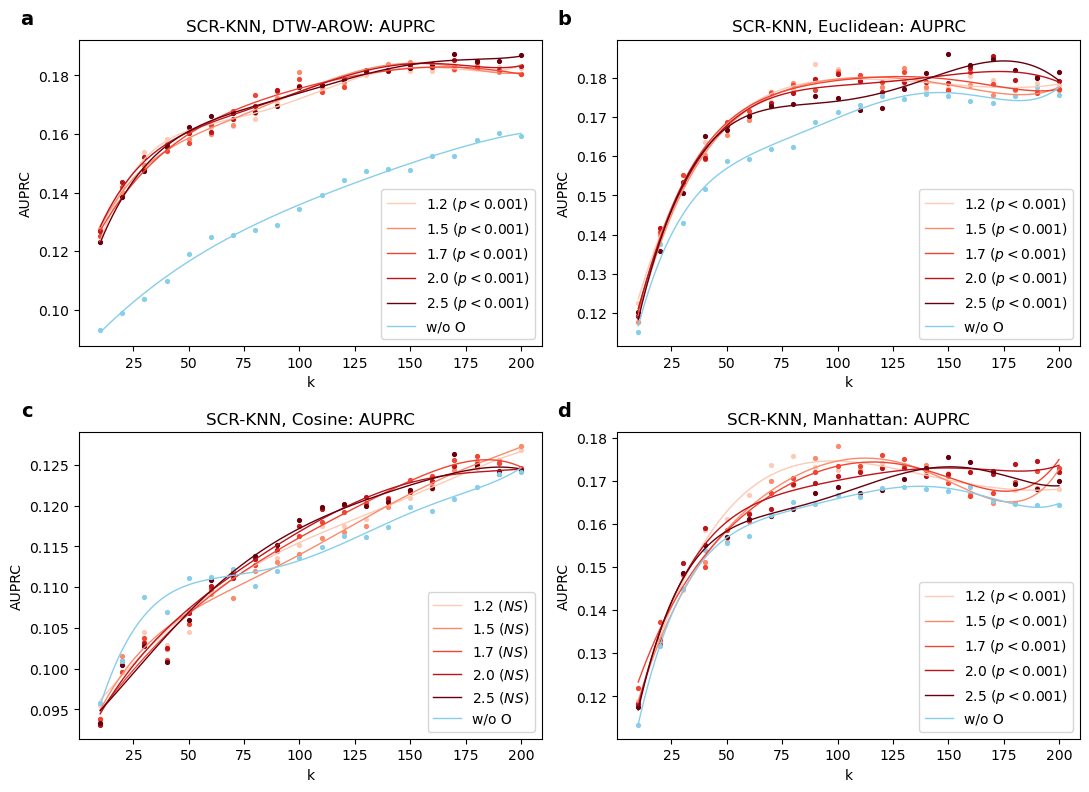

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Sensitivity_analysis/SCR-KNN-AUPRC.tif


In [73]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8)) 

metric = "AUPRC"

plot_sensitivity_analysis(axs[0, 0], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["KNN"]["DTW"], metric, "SCR-KNN, DTW-AROW: %s"%(metric),'KNN')
plot_sensitivity_analysis(axs[0, 1], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["KNN"]["Euc"], metric, "SCR-KNN, Euclidean: %s"%(metric),'KNN')
plot_sensitivity_analysis(axs[1, 0], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["KNN"]["Cos"], metric, "SCR-KNN, Cosine: %s"%(metric),'KNN')
plot_sensitivity_analysis(axs[1, 1], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["KNN"]["Manh"], metric, "SCR-KNN, Manhattan: %s"%(metric),'KNN')
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "SCR-KNN-AUPRC")

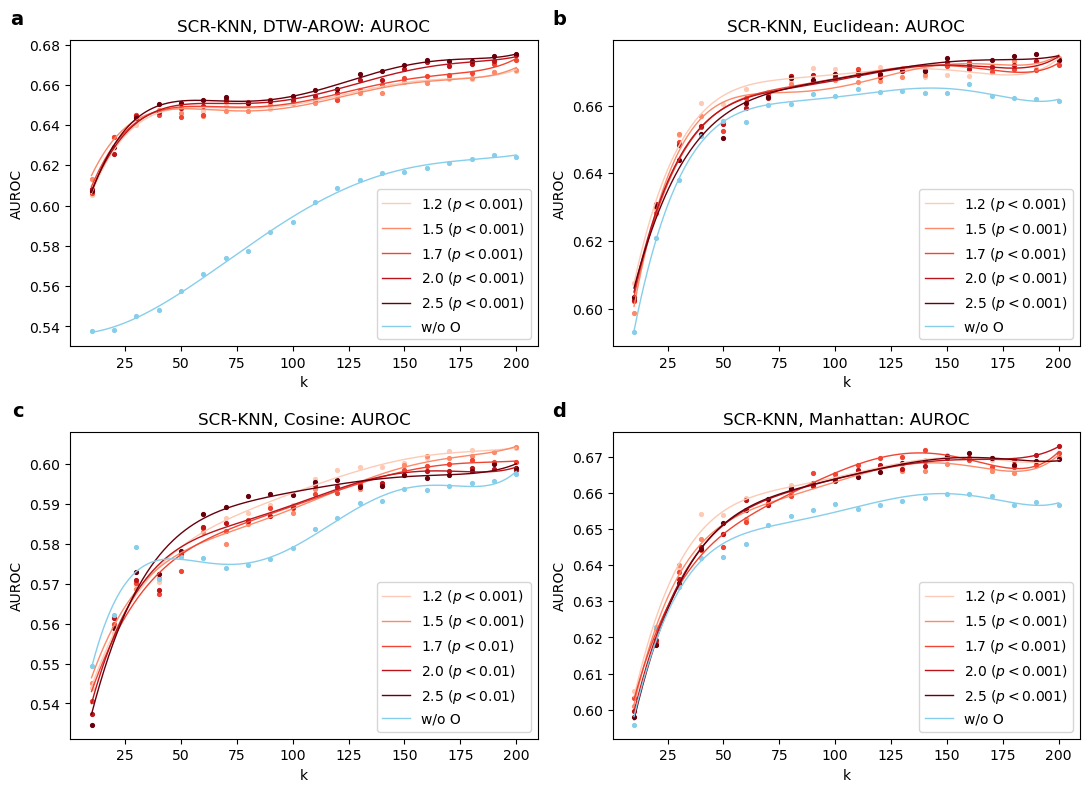

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Sensitivity_analysis/SCR-KNN-AUROC.tif


In [74]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8)) 

metric = "AUROC"

plot_sensitivity_analysis(axs[0, 0], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["KNN"]["DTW"], metric, "SCR-KNN, DTW-AROW: %s"%(metric),'KNN')
plot_sensitivity_analysis(axs[0, 1], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["KNN"]["Euc"], metric, "SCR-KNN, Euclidean: %s"%(metric),'KNN')
plot_sensitivity_analysis(axs[1, 0], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["KNN"]["Cos"], metric, "SCR-KNN, Cosine: %s"%(metric),'KNN')
plot_sensitivity_analysis(axs[1, 1], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["KNN"]["Manh"], metric, "SCR-KNN, Manhattan: %s"%(metric),'KNN')
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "SCR-KNN-AUROC")

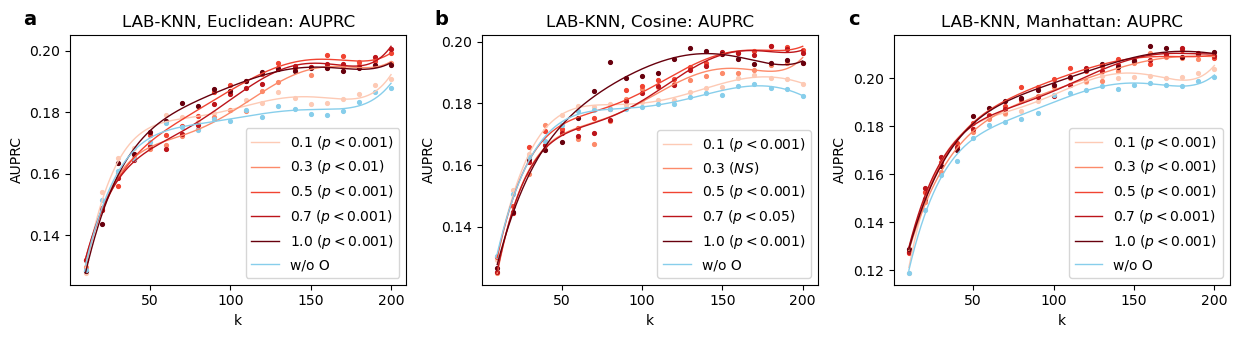

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Sensitivity_analysis/LAB-KNN-AUPRC.tif


In [75]:
fig, axs = plt.subplots(1, 3, figsize=(12.5, 3.5)) 

metric = "AUPRC"

plot_sensitivity_analysis(axs[0], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["KNN"]["Euc"], metric, "LAB-KNN, Euclidean: %s"%(metric),'KNN')
plot_sensitivity_analysis(axs[1], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["KNN"]["Cos"], metric, "LAB-KNN, Cosine: %s"%(metric),'KNN')
plot_sensitivity_analysis(axs[2], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["KNN"]["Manh"], metric, "LAB-KNN, Manhattan: %s"%(metric),'KNN')
add_subplot_index(axs, 1, 3)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "LAB-KNN-AUPRC")

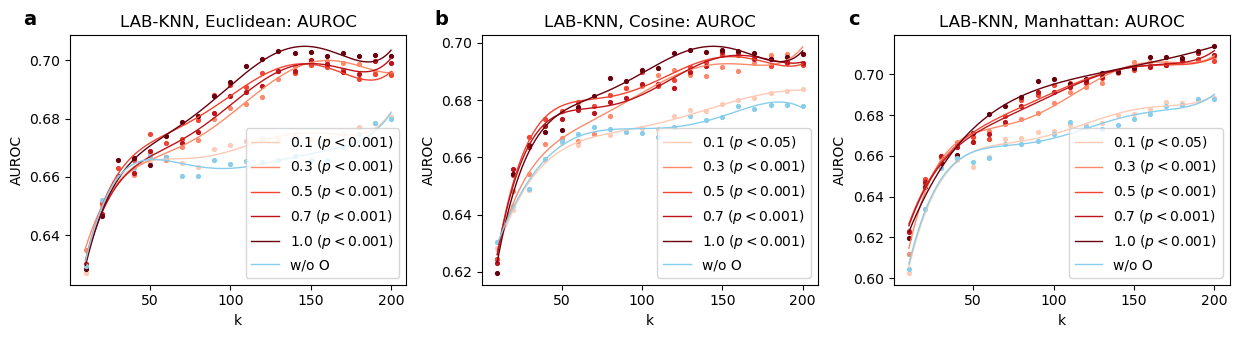

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Sensitivity_analysis/LAB-KNN-AUROC.tif


In [76]:
fig, axs = plt.subplots(1, 3, figsize=(12.5, 3.5)) 

metric = "AUROC"

plot_sensitivity_analysis(axs[0], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["KNN"]["Euc"], metric, "LAB-KNN, Euclidean: %s"%(metric),'KNN')
plot_sensitivity_analysis(axs[1], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["KNN"]["Cos"], metric, "LAB-KNN, Cosine: %s"%(metric),'KNN')
plot_sensitivity_analysis(axs[2], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["KNN"]["Manh"], metric, "LAB-KNN, Manhattan: %s"%(metric),'KNN')
add_subplot_index(axs, 1, 3)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "LAB-KNN-AUROC")

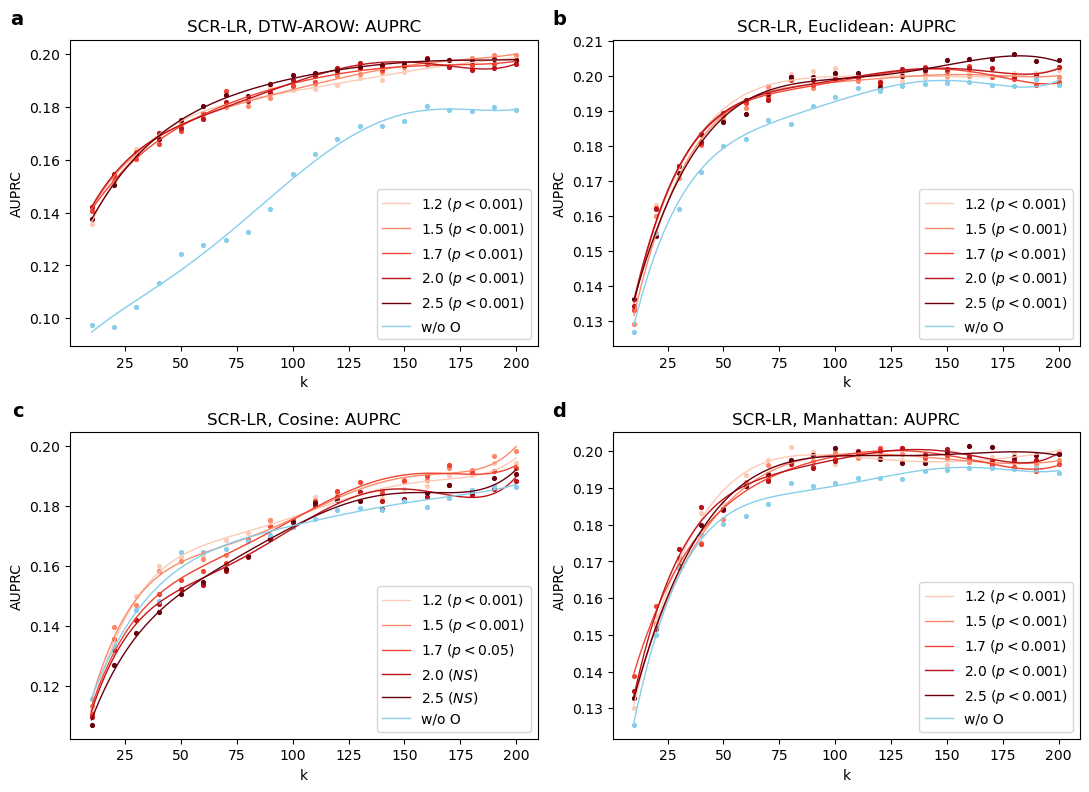

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Sensitivity_analysis/SCR-LR-AUPRC.tif


In [77]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8)) 

metric = "AUPRC"

plot_sensitivity_analysis(axs[0, 0], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["LR"]["DTW"], metric, "SCR-LR, DTW-AROW: %s"%(metric),'LR')
plot_sensitivity_analysis(axs[0, 1], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["LR"]["Euc"], metric, "SCR-LR, Euclidean: %s"%(metric),'LR')
plot_sensitivity_analysis(axs[1, 0], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["LR"]["Cos"], metric, "SCR-LR, Cosine: %s"%(metric),'LR')
plot_sensitivity_analysis(axs[1, 1], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["LR"]["Manh"], metric, "SCR-LR, Manhattan: %s"%(metric),'LR')
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "SCR-LR-AUPRC")

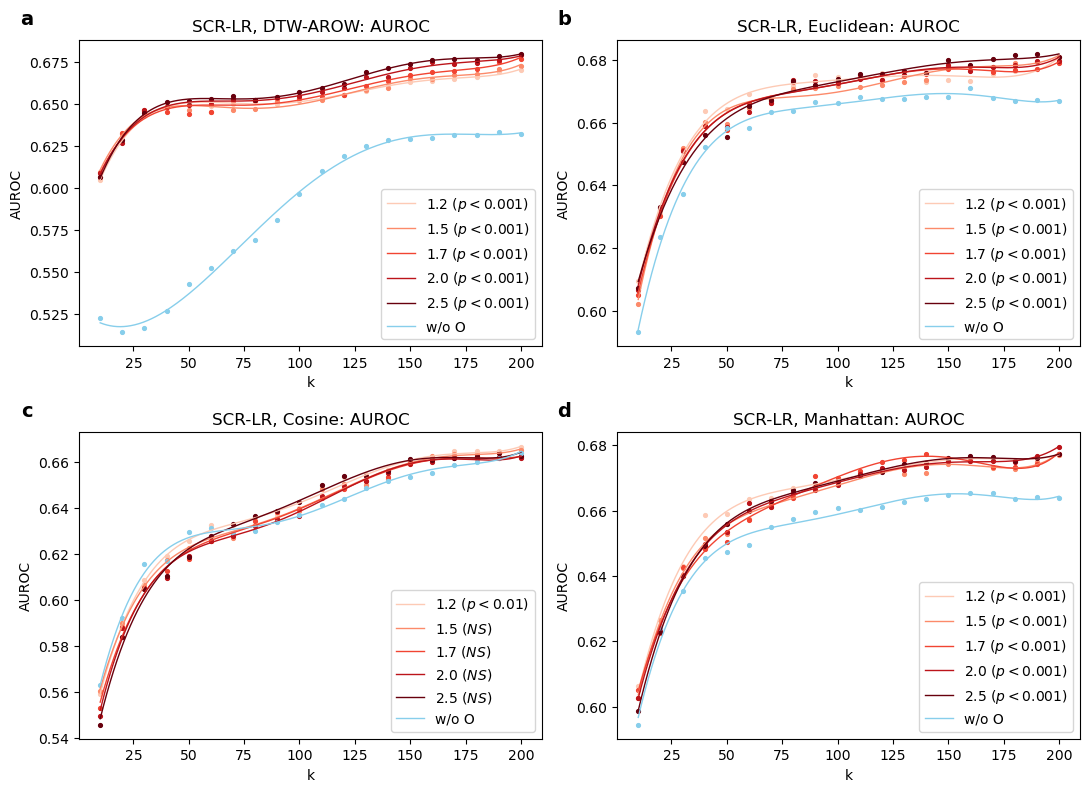

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Sensitivity_analysis/SCR-LR-AUROC.tif


In [78]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8)) 

metric = "AUROC"

plot_sensitivity_analysis(axs[0, 0], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["LR"]["DTW"], metric, "SCR-LR, DTW-AROW: %s"%(metric),'LR')
plot_sensitivity_analysis(axs[0, 1], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["LR"]["Euc"], metric, "SCR-LR, Euclidean: %s"%(metric),'LR')
plot_sensitivity_analysis(axs[1, 0], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["LR"]["Cos"], metric, "SCR-LR, Cosine: %s"%(metric),'LR')
plot_sensitivity_analysis(axs[1, 1], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["LR"]["Manh"], metric, "SCR-LR, Manhattan: %s"%(metric),'LR')
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "SCR-LR-AUROC")

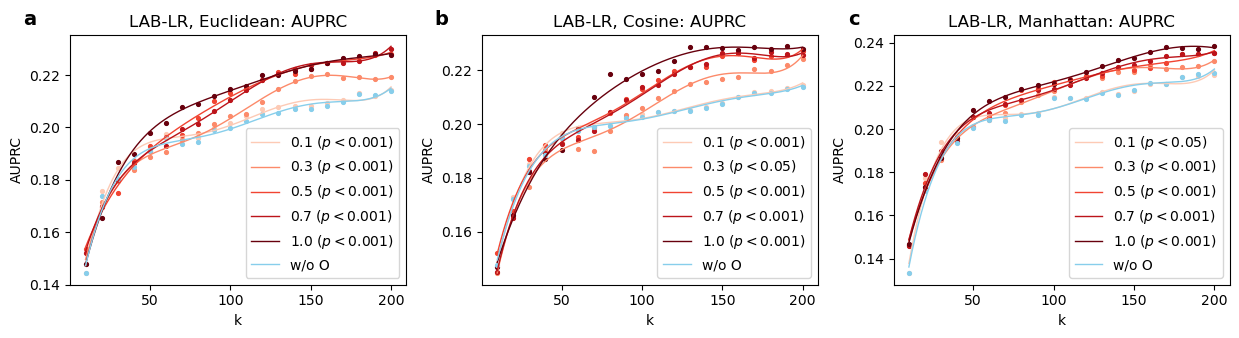

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Sensitivity_analysis/LAB-LR-AUPRC.tif


In [79]:
fig, axs = plt.subplots(1, 3, figsize=(12.5, 3.5)) 

metric = "AUPRC"

plot_sensitivity_analysis(axs[0], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["LR"]["Euc"], metric, "LAB-LR, Euclidean: %s"%(metric),'LR')
plot_sensitivity_analysis(axs[1], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["LR"]["Cos"], metric, "LAB-LR, Cosine: %s"%(metric),'LR')
plot_sensitivity_analysis(axs[2], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["LR"]["Manh"], metric, "LAB-LR, Manhattan: %s"%(metric),'LR')
add_subplot_index(axs, 1, 3)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "LAB-LR-AUPRC")

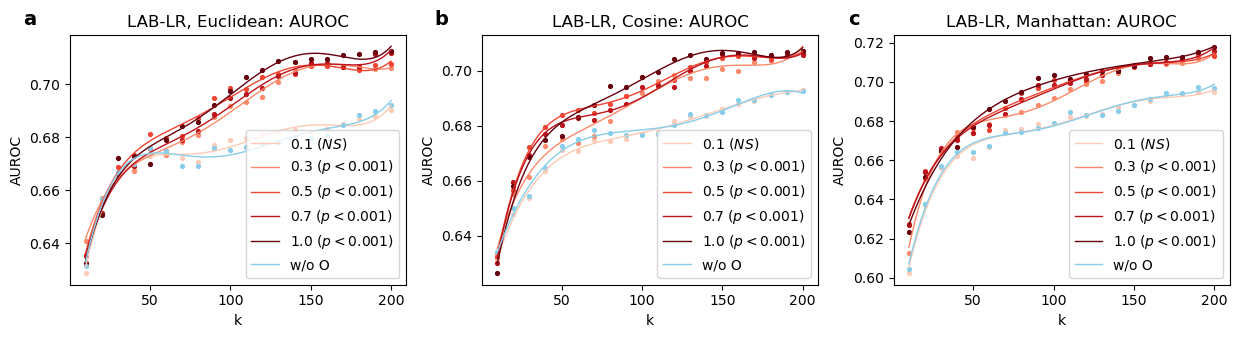

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Sensitivity_analysis/LAB-LR-AUROC.tif


In [80]:
fig, axs = plt.subplots(1, 3, figsize=(12.5, 3.5)) 

metric = "AUROC"

plot_sensitivity_analysis(axs[0], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["LR"]["Euc"], metric, "LAB-LR, Euclidean: %s"%(metric),'LR')
plot_sensitivity_analysis(axs[1], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["LR"]["Cos"], metric, "LAB-LR, Cosine: %s"%(metric),'LR')
plot_sensitivity_analysis(axs[2], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["LR"]["Manh"], metric, "LAB-LR, Manhattan: %s"%(metric),'LR')
add_subplot_index(axs, 1, 3)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "LAB-LR-AUROC")

# Main Text Combined Plot

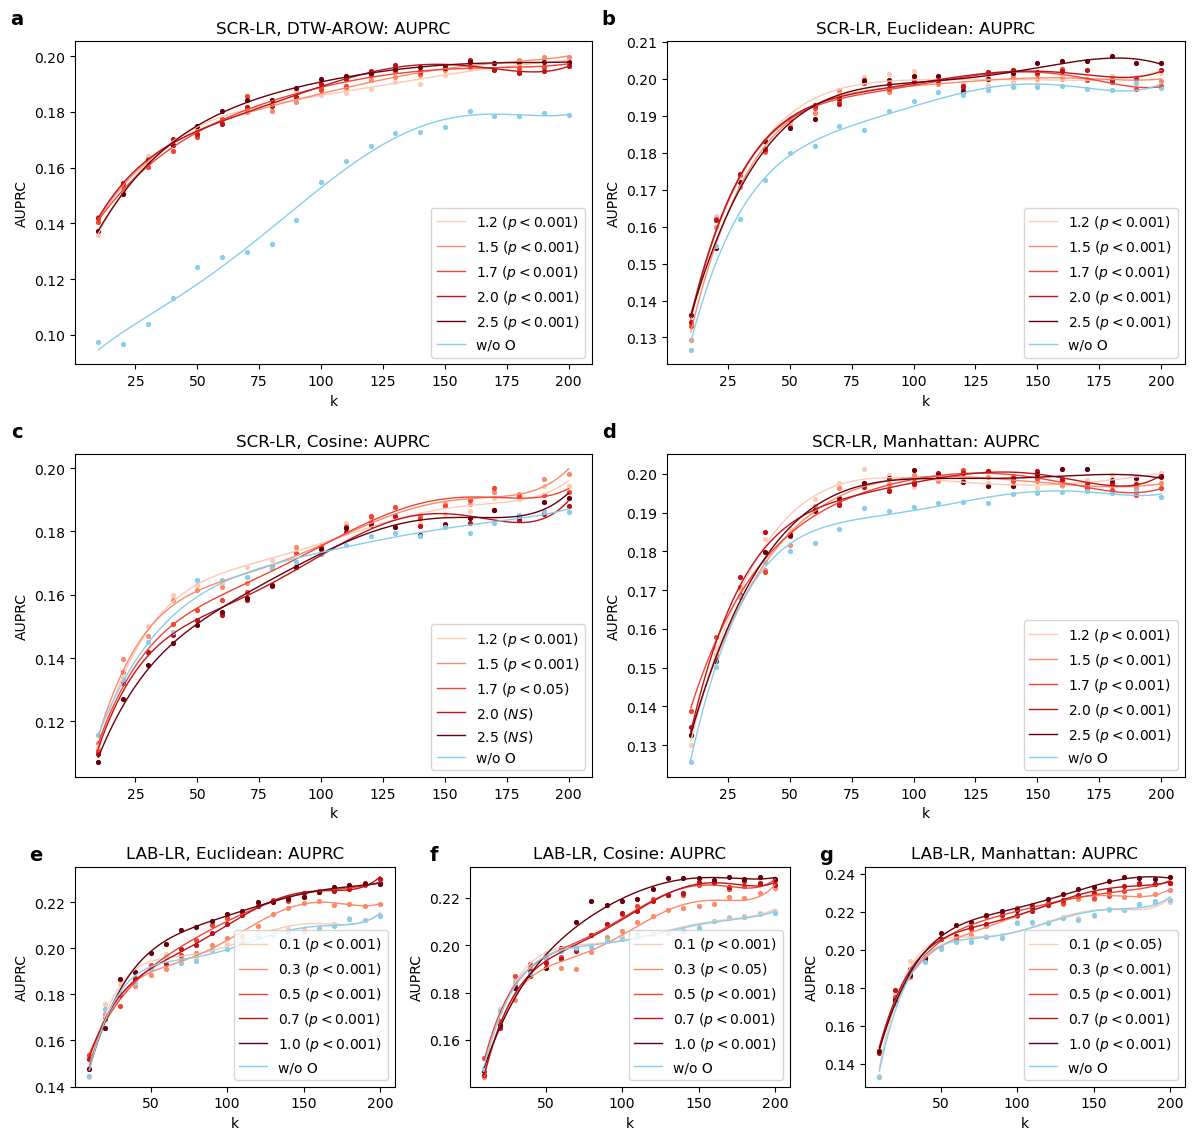

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Sensitivity_analysis/Combined-Figure-LR-AUPRC.tif


In [87]:
from matplotlib.gridspec import GridSpec

# Create the figure and gridspec
fig = plt.figure(figsize=(12, 11.5))
gs = GridSpec(11, 6, figure=fig) 

# Define the metric
metric = "AUPRC"

# Plot the 2x2 grid (SCR-LR plots)
axs_2x2 = [fig.add_subplot(gs[0:4, 0:3]),  # Top-left
           fig.add_subplot(gs[0:4, 3:6]),  # Top-right
           fig.add_subplot(gs[4:8, 0:3]),    # Bottom-left
           fig.add_subplot(gs[4:8, 3:6])]    # Bottom-right

plot_sensitivity_analysis(axs_2x2[0], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["LR"]["DTW"], metric, "SCR-LR, DTW-AROW: %s"%(metric), 'LR')
plot_sensitivity_analysis(axs_2x2[1], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["LR"]["Euc"], metric, "SCR-LR, Euclidean: %s"%(metric), 'LR')
plot_sensitivity_analysis(axs_2x2[2], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["LR"]["Cos"], metric, "SCR-LR, Cosine: %s"%(metric), 'LR')
plot_sensitivity_analysis(axs_2x2[3], k_sizes_test, sd_SCR_space_ticks, 
                          sensitivity_analysis_results["SCR"]["LR"]["Manh"], metric, "SCR-LR, Manhattan: %s"%(metric), 'LR')

# Plot the 1x3 grid (LAB-LR plots)
axs_1x3 = [fig.add_subplot(gs[8:11, 0:2]),   # Bottom-left
           fig.add_subplot(gs[8:11, 2:4]),   # Bottom-center
           fig.add_subplot(gs[8:11, 4:6])]   # Bottom-right

plot_sensitivity_analysis(axs_1x3[0], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["LR"]["Euc"], metric, "LAB-LR, Euclidean: %s"%(metric), 'LR')
plot_sensitivity_analysis(axs_1x3[1], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["LR"]["Cos"], metric, "LAB-LR, Cosine: %s"%(metric), 'LR')
plot_sensitivity_analysis(axs_1x3[2], k_sizes_test, top_rates_space_ticks, 
                          sensitivity_analysis_results["LAB"]["LR"]["Manh"], metric, "LAB-LR, Manhattan: %s"%(metric), 'LR')

# Add subplot indices ('a', 'b', ..., 'g')
subplots = axs_2x2 + axs_1x3  # Combine all subplot axes
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

for ax, label in zip(subplots, labels):
    # Add text label at the top-left corner of each subplot
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=14, 
            fontweight='bold', va='top', ha='right')


# Adjust layout and save the combined figure
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "Combined-Figure-LR-AUPRC")